In [3]:
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = 1


## Standard libraries
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('viridis')
%matplotlib inline
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 0 #2.0
#import seaborn as sns
#sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision import transforms
import numpy as np
from PIL import Image

# PyTorch Lightning
import pytorch_lightning as pl
#try:
#    import pytorch_lightning as pl
#except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
#    !pip install --quiet pytorch-lightning>=1.4
#    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
#DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
#CHECKPOINT_PATH = '/home/azamat.kaibaldiyev/Tasmania_ohara_labels/checkpoints_images/'
CHECKPOINT_PATH = '/home/azamat.kaibaldiyev/Tasmania_ohara_labels/checkpoints_Ohara_all_images/'

# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

[rank: 0] Global seed set to 42


Device: cuda:0
Number of workers: 64


<Figure size 640x480 with 0 Axes>

In [5]:
#all images: from professor
import glob
imgs = sorted(glob.glob('Tasmania_ohara_labels/Ohara_images_from_prof/*/*'))
print(len(imgs))
imgs[:7]

36663


['Tasmania_ohara_labels/Ohara_images_from_prof/i20081006_231255_gtif/PR_20081006_231732_335_LC16.tif',
 'Tasmania_ohara_labels/Ohara_images_from_prof/i20081006_231255_gtif/PR_20081006_231733_335_LC16.tif',
 'Tasmania_ohara_labels/Ohara_images_from_prof/i20081006_231255_gtif/PR_20081006_231734_340_LC16.tif',
 'Tasmania_ohara_labels/Ohara_images_from_prof/i20081006_231255_gtif/PR_20081006_231735_340_LC16.tif',
 'Tasmania_ohara_labels/Ohara_images_from_prof/i20081006_231255_gtif/PR_20081006_231736_340_LC16.tif',
 'Tasmania_ohara_labels/Ohara_images_from_prof/i20081006_231255_gtif/PR_20081006_231737_341_LC16.tif',
 'Tasmania_ohara_labels/Ohara_images_from_prof/i20081006_231255_gtif/PR_20081006_231738_341_LC16.tif']

In [27]:
rasterio.open('Tasmania_ohara_labels/Ohara_images_from_prof/i20081007_224547_gtif/PR_20081007_230308_119_LC16.tif').read()

array([[[24, 22, 19, ...,  4,  1,  0],
        [28, 27, 25, ...,  3,  2,  1],
        [13, 17, 20, ...,  2,  4,  5],
        ...,
        [18, 19, 20, ...,  8,  5,  2],
        [11,  9,  7, ...,  6,  2,  1],
        [18, 14,  9, ...,  6,  1,  0]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  1, ...,  0,  0,  0],
        [ 2,  2,  1, ...,  0,  0,  0],
        ...,
        [ 2,  1,  1, ...,  0,  0,  0],
        [ 2,  2,  0, ...,  0,  0,  0],
        [ 3,  2,  0, ...,  0,  0,  0]],

       [[18, 16, 12, ...,  0,  0,  0],
        [14, 11,  8, ...,  0,  0,  0],
        [10,  7,  5, ...,  0,  0,  0],
        ...,
        [12,  9,  7, ...,  1,  3,  5],
        [ 9, 11, 11, ...,  0,  1,  2],
        [ 6, 12, 16, ...,  0,  0,  0]]], dtype=uint8)

In [28]:
import glob
imgs = sorted(glob.glob('Tasmania_ohara_labels/i20081007_224547_cv_RGB/*'))
print(len(imgs))
imgs[:7]

2497


['Tasmania_ohara_labels/i20081007_224547_cv_RGB/PR_20081007_230308_119_LC16.png',
 'Tasmania_ohara_labels/i20081007_224547_cv_RGB/PR_20081007_230318_117_LC16.png',
 'Tasmania_ohara_labels/i20081007_224547_cv_RGB/PR_20081007_230320_121_LC16.png',
 'Tasmania_ohara_labels/i20081007_224547_cv_RGB/PR_20081007_230327_121_LC16.png',
 'Tasmania_ohara_labels/i20081007_224547_cv_RGB/PR_20081007_230328_123_LC16.png',
 'Tasmania_ohara_labels/i20081007_224547_cv_RGB/PR_20081007_230329_122_LC16.png',
 'Tasmania_ohara_labels/i20081007_224547_cv_RGB/PR_20081007_230332_121_LC16.png']

In [29]:
import PIL
np.array(PIL.Image.open(imgs[0])).reshape((3, 1024, 1360))

array([[[24,  0, 14, ...,  0,  0,  2],
        [ 0,  0,  5, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  3,  1, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [21,  0,  0, ...,  0,  3,  0]],

       [[ 0,  3,  1, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 5,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [26,  4,  2, ...,  4,  6,  8],
        [13,  6, 33, ...,  0,  0,  0]],

       [[ 0,  0,  0, ...,  4,  0,  0],
        [26,  4,  2, ...,  4,  6,  8],
        [ 3,  6, 33, ...,  0,  0,  0],
        ...,
        [14,  4, 10, ...,  0,  2,  4],
        [ 0,  2,  1, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]]], dtype=uint8)

In [4]:

import glob
imgs = sorted(glob.glob('Tasmania_ohara_labels/Ohara_all_images_labels/image_labels/*'))
print(len(imgs))
imgs[:7]

11278


['Tasmania_ohara_labels/Ohara_all_images_labels/image_labels/PR_20081007_230307_118_LC16.png',
 'Tasmania_ohara_labels/Ohara_all_images_labels/image_labels/PR_20081007_230308_119_LC16.png',
 'Tasmania_ohara_labels/Ohara_all_images_labels/image_labels/PR_20081007_230309_117_LC16.png',
 'Tasmania_ohara_labels/Ohara_all_images_labels/image_labels/PR_20081007_230310_116_LC16.png',
 'Tasmania_ohara_labels/Ohara_all_images_labels/image_labels/PR_20081007_230311_116_LC16.png',
 'Tasmania_ohara_labels/Ohara_all_images_labels/image_labels/PR_20081007_230312_116_LC16.png',
 'Tasmania_ohara_labels/Ohara_all_images_labels/image_labels/PR_20081007_230313_115_LC16.png']

In [6]:
import pandas as pd
stereo_data_cols_names = ['Pose identifier', 'timestamp', 'Latitude', 'Longitude', 'X position (North)',
                         'Y position (East)', 'Z position (Depth)','X-axis Euler angle', 'Y-axis Euler angle',
                         'Z-axis Euler angle', 'Left image name', 'Right image name', 'Vehicle altitude', 
                         'Approx. bounding image radius', 'Likely trajectory cross-over point']
df_coords =  pd.read_csv('Tasmania_ohara_labels/stereo_pose_est.data',skiprows = np.arange(57),sep = "\t",
                    names = stereo_data_cols_names)
df_coords['Left image name'] = df_coords['Left image name'].str.strip()
df_coords['Right image name'] = df_coords['Right image name'].str.strip()
df_coords[-5:]


,Pose identifier,timestamp,Latitude,Longitude,X position (North),Y position (East),Z position (Depth),X-axis Euler angle,Y-axis Euler angle,Z-axis Euler angle,Left image name,Right image name,Vehicle altitude,Approx. bounding image radius,Likely trajectory cross-over point
11273,24650,1.223432e+09,-43.083210,147.974083,149.661403,-49.113566,32.423133,0.020202,-0.002820,1.265366,PR_20081008_021101_665_LC16.png,PR_20081008_021101_665_RM16.png,1.950,0.659772,0
11274,24652,1.223432e+09,-43.083207,147.974081,150.015155,-49.238257,32.383773,0.011275,0.009641,1.413536,PR_20081008_021102_664_LC16.png,PR_20081008_021102_664_RM16.png,2.050,0.693607,0
11275,24654,1.223432e+09,-43.083204,147.974080,150.373901,-49.343201,32.374147,0.010260,0.003011,1.521798,PR_20081008_021103_664_LC16.png,PR_20081008_021103_664_RM16.png,2.042,0.690900,0
11276,24656,1.223432e+09,-43.083200,147.974079,150.759128,-49.428537,32.362804,0.018431,-0.003524,1.529485,PR_20081008_021104_665_LC16.png,PR_20081008_021104_665_RM16.png,2.000,0.676689,0
11277,24658,1.223432e+09,-43.083197,147.974077,151.154256,-49.575250,32.360743,0.021910,0.006140,1.460616,PR_20081008_021105_662_LC16.png,PR_20081008_021105_662_RM16.png,2.087,0.706125,0


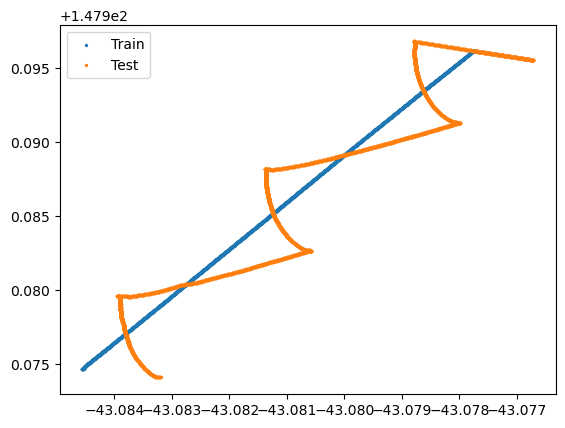

In [18]:
dim = 4460
plt.scatter(df_coords['Latitude'][:dim],df_coords['Longitude'][:dim], label = 'Train',s=2)
plt.scatter(df_coords['Latitude'][dim:],df_coords['Longitude'][dim:], label = 'Test',s=2)
plt.legend()

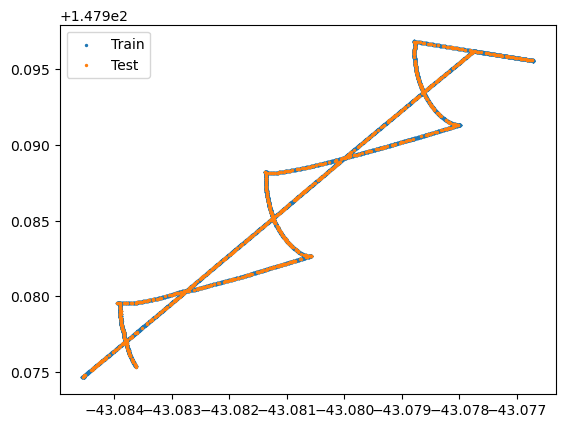

In [17]:
plt.scatter(df_coords['Latitude'][train_set_indexes],df_coords['Longitude'][train_set_indexes], label = 'Train', s= 2)
plt.scatter(df_coords['Latitude'][test_set_indexes],df_coords['Longitude'][test_set_indexes], label = 'Test', s = 2)
plt.legend()

In [ ]:
df_merged_images['Left image name'] = df_merged_images['Left image name'].str.split('/').str[-1]
df_coords['Left image name'] = df_coords['Left image name'].str.split('.').str[0]+'.tif'

Text(0, 0.5, 'Number of instances')

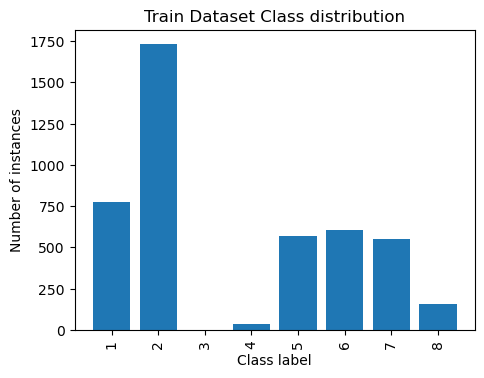

In [27]:
fig = plt.figure(figsize = (4,3))
ax = fig.add_axes([0,0,1,1])
classes = [1,2,3,4,5,6,7,8]
ax.bar(classes,np.bincount(pd.merge(df_merged_images, df_coords[:dim], on = 'Left image name')['cluster_id']))
plt.xticks(rotation='vertical')
plt.title('Train Dataset Class distribution')
plt.xlabel("Class label")
plt.ylabel("Number of instances")
#plt.show()
#plt.savefig('Images_thesis/Ohara_distribution.png',format="png", dpi=resolution_value, bbox_inches='tight')

Text(0, 0.5, 'Number of instances')

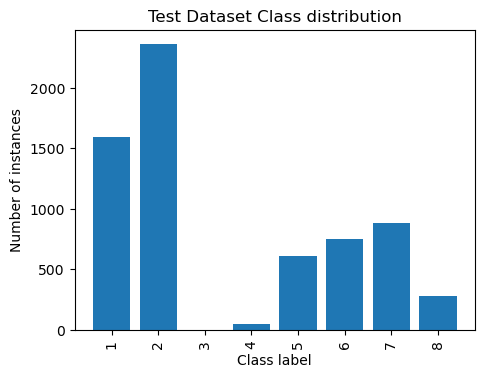

In [28]:
fig = plt.figure(figsize = (4,3))
ax = fig.add_axes([0,0,1,1])
classes = [1,2,3,4,5,6,7,8]
ax.bar(classes,np.bincount(pd.merge(df_merged_images, df_coords[dim:], on = 'Left image name')['cluster_id']))
plt.xticks(rotation='vertical')
plt.title('Test Dataset Class distribution')
plt.xlabel("Class label")
plt.ylabel("Number of instances")
#plt.show()
#plt.savefig('Images_thesis/Ohara_distribution.png',format="png", dpi=resolution_value, bbox_inches='tight')

In [9]:
# with open('files_remove_indices/Ohara_images_11000_labels_train_set_indexes.npy', 'wb') as f:
#     np.save(f, train_index)

# with open('files_remove_indices/Ohara_images_11000_labels_test_set_indexes.npy', 'wb') as f:
#     np.save(f, test_index)

with open('files_remove_indices/Ohara_images_11000_labels_train_set_indexes.npy', 'rb') as f:
    train_set_indexes = np.load(f)

with open('files_remove_indices/Ohara_images_11000_labels_test_set_indexes.npy', 'rb') as f:
    test_set_indexes = np.load(f)
    
print(len(train_set_indexes))
print(len(test_set_indexes))

9870
1097


In [43]:
import pandas as pd
df_labels =  pd.read_csv('Tasmania_ohara_labels/image_labels.data',skiprows = np.arange(15),sep = "\t")
                    #names = ['row_id','timestamp','left_image','right_image','cluster_id'], )
df_labels.rename(columns = {'left_image':'Left image name', 'right_image':'Right image name'}, inplace = True)
df_labels['Left image name'] = df_labels['Left image name'].str.split('.').str[0].str.strip()+'.tif'
df_labels['Right image name'] = df_labels['Right image name'].str.strip()
df_labels[-2:]

,row_id,timestamp,Left image name,Right image name,cluster_id
10965,11276,1.223432e+09,PR_20081008_021104_665_LC16.tif,PR_20081008_021104_665_RM16.png,6
10966,11277,1.223432e+09,PR_20081008_021105_662_LC16.tif,PR_20081008_021105_662_RM16.png,6


In [44]:
df_images = pd.DataFrame(imgs, columns =['Left image name'])
df_images['Left image name'] = df_images['Left image name'].str.split('/').str[-1]
df_images[-2:]

,Left image name
36661,PR_20081010_000331_192_LC16.tif
36662,PR_20081010_000332_192_LC16.tif


In [45]:
df_merged_images = pd.merge(df_labels, df_images, on = 'Left image name')
df_merged_images['Left image name'] = 'Tasmania_ohara_labels/Ohara_images_from_prof/i20081007_224547_gtif/'+df_merged_images['Left image name']
df_merged_images['cluster_id'] = df_merged_images['cluster_id'].replace([1, 2, 3 ,4,5, 6, 7, 8], [0, 1, 2, 3 ,4,5, 6, 7])
df_merged_images[-2:]

,row_id,timestamp,Left image name,Right image name,cluster_id
10965,11276,1.223432e+09,Tasmania_ohara_labels/Ohara_images_from_prof/i...,PR_20081008_021104_665_RM16.png,5
10966,11277,1.223432e+09,Tasmania_ohara_labels/Ohara_images_from_prof/i...,PR_20081008_021105_662_RM16.png,5


In [37]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import glob
import rasterio
dataset_path = 'Tasmania_ohara_labels/Ohara_images_from_prof/*/'
dataset_path_with_labels = 'Tasmania_ohara_labels/Ohara_all_images_labels/image_labels/'



class SwedishDataset(Dataset):
    def __init__(self,  transform  = None, dataset_path = None, remove_list = None, labels = False):
        self.imgs_path = dataset_path
        self.file_list_dem = sorted(glob.glob(self.imgs_path + "*"))
        if labels:
            self.file_list_dem = df_merged_images['Left image name']

        self.transform = transform
        self.labels = labels
        
    def __len__(self):
        return len(self.file_list_dem)

          
    def __getitem__(self, idx):
        img_path_dem = self.file_list_dem[idx]
        # open method used to open different extension image file
        img_raster_dem = Image.open(img_path_dem)
        if self.labels:
            label = int(df_merged_images['cluster_id'][idx])
        else:
            label = 'no_label'


        if self.transform:
            img_raster_dem = self.transform(img_raster_dem)
        
        
        return [img_raster_dem, label]
    
    
    
    
    
def normalize_input_for_dem(test_iter):
    #test_iter = torch.from_numpy(test_iter)
    input_images = test_iter.float()
    #maxv = 822
    #minv = -37
    batch_size = input_images.shape[0]
    cmin = torch.amin(input_images,(1,2)).reshape((batch_size,1,1))
    cmax = torch.amax(input_images,(1,2)).reshape((batch_size,1,1))
    return (input_images-cmin)/(cmax-cmin) #(input_images-minv)/(maxv-minv) #(input_images-cmin)/(cmax-cmin)

class Normalize_range01:
    #bring to range 0 to 1

    def __init__(self, p=1):
        self.p = 1

    def __call__(self, x):
        result = normalize_input_for_dem(x)
        return result

    def __repr__(self):
        return "custom augmentation"
    
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]
    
    


contrast_transforms = transforms.Compose([transforms.ToTensor(),
                                          transforms.Resize(size = 100),
                                          #Normalize_range01(),
                                          #transforms.ToPILImage(), 
                                          #transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=100),
                                          #transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
                                          #transforms.RandomGrayscale(p=0.2),
                                          #transforms.GaussianBlur(kernel_size=9),
                                          #transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

from torch.utils.data import random_split
import math
dataset = SwedishDataset(transform = ContrastiveTransformations(contrast_transforms, n_views = 2), dataset_path = dataset_path)

print(len(dataset))
dataset_len =len(dataset)

train_dataset = torch.utils.data.Subset(dataset, train_set_indexes)
test_dataset = torch.utils.data.Subset(dataset, test_set_indexes)
print(len(train_dataset))
print(len(test_dataset))

#print(dataset[4][0][0].shape)
#dataset[4][1].shape


36663


NameError: name 'train_set_indexes' is not defined

In [10]:
dataset[0][0][0].shape

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 100, 100])

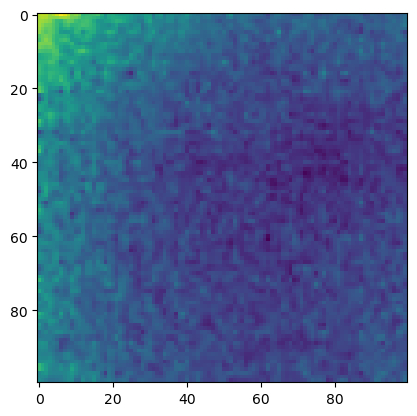

In [11]:
plt.imshow(dataset[0][0][0][0])

In [12]:
dataset[0][0]

[tensor([[[-0.8992, -0.8975, -0.8983,  ..., -0.8644, -0.8668, -0.8711],
          [-0.9155, -0.9020, -0.8879,  ..., -0.8640, -0.8586, -0.8589],
          [-0.9213, -0.9051, -0.8898,  ..., -0.8738, -0.8731, -0.8748],
          ...,
          [-0.8886, -0.8924, -0.8956,  ..., -0.9006, -0.8844, -0.8662],
          [-0.8816, -0.8888, -0.8936,  ..., -0.8938, -0.8816, -0.8667],
          [-0.9030, -0.8900, -0.8804,  ..., -0.8810, -0.8777, -0.8739]],
 
         [[-0.9221, -0.9179, -0.9137,  ..., -0.8849, -0.8871, -0.8902],
          [-0.9181, -0.9168, -0.9152,  ..., -0.8956, -0.8908, -0.8869],
          [-0.9085, -0.9088, -0.9100,  ..., -0.9072, -0.8982, -0.8871],
          ...,
          [-0.9093, -0.9153, -0.9181,  ..., -0.9164, -0.9095, -0.9009],
          [-0.8984, -0.9039, -0.9070,  ..., -0.9133, -0.9072, -0.9020],
          [-0.8991, -0.9062, -0.9114,  ..., -0.9096, -0.9125, -0.9187]],
 
         [[-0.8221, -0.8223, -0.8257,  ..., -0.8272, -0.8256, -0.8216],
          [-0.8356, -0.8293,

# Model

In [11]:
!wandb login --relogin "40706c6c21e200af3bdb3840883f22e665e74441"

wandb: Appending key for api.wandb.ai to your netrc file: /home/azamat.kaibaldiyev/.netrc


In [12]:
import wandb
import random
from sklearn.metrics import classification_report

epochs = 300
lr = 1e-5
#wandb.init(settings=wandb.Settings(start_method="fork"))
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Contrastive_SimCLR_Ohara",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "SimCLR",
    "dataset": "Ohara_dataset_images",
    "epochs": epochs,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kaibaldiyev (self-sup-segm). Use `wandb login --relogin` to force relogin


In [13]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        #model = torchvision.models.resnet18()
        num_input_channel = 3
        self.convnet.conv1 = nn.Conv2d(num_input_channel, 64, kernel_size=7, stride=2, padding=3,bias=False)
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        wandb.log({'SimCLR_'+mode+'_loss':nll})
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        wandb.log({'SimCLR_'+mode+'_acc_top1':(sim_argsort == 0).float().mean()})
        wandb.log({'SimCLR_'+mode+'_acc_top5':(sim_argsort < 5).float().mean()})
        wandb.log({'SimCLR_'+mode+'_acc_mean_pos': 1+sim_argsort.float().mean()})
        
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')
        
    def forward(self, x):
        return self.convnet(x)
        
    

In [14]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(log_every_n_steps=10, default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                       drop_last=True, pin_memory=True, num_workers=2)
        val_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=2)
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [15]:
simclr_model = train_simclr(batch_size=256,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=2)

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/azamat.kaibaldiyev/miniconda3/envs/contrastive ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[rank: 0] Global seed set to 42
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/azamat.kaibaldiyev/miniconda3/envs/contrastive ...
  rank_z

Sanity Checking: 0it [00:00, ?it/s]

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tens

Training: 0it [00:00, ?it/s]

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResi

Validation: 0it [00:00, ?it/s]

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResi

Validation: 0it [00:00, ?it/s]

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
`Trainer.fit` stopped: `max_epochs=2` reached.


# Downstream Task

In [12]:
!wandb login --relogin "40706c6c21e200af3bdb3840883f22e665e74441"

wandb: Appending key for api.wandb.ai to your netrc file: /home/azamat.kaibaldiyev/.netrc


In [46]:
import wandb
import random
from sklearn.metrics import classification_report

epochs = 300
lr = 1e-5
#wandb.init(settings=wandb.Settings(start_method="fork"))
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Contrastive_SimCLR_Ohara",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "Downstream_Logreg",
    "dataset": "Ohara_dataset_images_36000",
    "epochs": epochs,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kaibaldiyev (self-sup-segm). Use `wandb login --relogin` to force relogin


In [47]:
class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=300):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        #self.model = nn.Linear(feature_dim, num_classes)
        self.model = nn.Sequential(
                        nn.Linear(feature_dim, num_classes),
                      )
        

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.6),
                                                                  int(self.hparams.max_epochs*0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        #criterion = F.cross_entropy()
        
        feats, labels = batch
        preds = self.model(feats)
        #print('preds', preds)
        #print('labels:', labels)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        wandb.log({'Downstream_' + mode+'_loss': loss})
        wandb.log({'Downstream_' + mode+'_acc': acc})
        
        lightning_optimizer = self.optimizers()  # self = your model
        current_lr = lightning_optimizer.optimizer.param_groups[0]['lr']
        wandb.log({'Downstream_' + mode+'_learningrate': current_lr})

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

In [52]:

with open('files_remove_indices/Ohara_images_11000_labels_train_set_indexes.npy', 'rb') as f:
    train_set_indexes_labels = np.load(f)

with open('files_remove_indices/Ohara_images_11000_labels_test_set_indexes.npy', 'rb') as f:
    test_set_indexes_labels = np.load(f)
    
print(len(train_set_indexes_labels))
print(len(test_set_indexes_labels))

9870
1097


In [48]:
img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(size = (100,100)),
                                     #Normalize_range01(),
                                     transforms.Normalize((0.5,), (0.5,))])

dataset = SwedishDataset(transform = img_transforms , dataset_path=dataset_path_with_labels ,labels = True)

#For random split
# train_dataset = torch.utils.data.Subset(dataset, train_set_indexes_labels)
# test_dataset = torch.utils.data.Subset(dataset, test_set_indexes_labels)

#For different lines
train_dataset = torch.utils.data.Subset(dataset, np.arange(dim))
test_dataset = torch.utils.data.Subset(dataset, np.arange(dim, len(dataset)))

print(len(dataset))
print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))

10967
Number of training examples: 4460
Number of test examples: 6507


In [49]:
dataset[0]

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[tensor([[[-0.8320, -0.8689, -0.9053,  ..., -0.9666, -0.9564, -0.8854],
          [-0.8600, -0.8950, -0.9362,  ..., -0.9547, -0.7547, -0.7574],
          [-0.8910, -0.9758, -0.8612,  ..., -0.6243, -0.8294, -0.7730],
          ...,
          [-0.9048, -0.9422, -0.9588,  ..., -0.8929, -0.9237, -0.9557],
          [-0.9788, -0.8982, -0.9328,  ..., -0.9093, -0.8997, -0.8712],
          [-0.8296, -0.9461, -0.9176,  ..., -0.7916, -0.9594, -0.9248]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8853],
          [-0.9765, -1.0000, -1.0000,  ..., -1.0000, -0.8728, -0.9969],
          [-1.0000, -1.0000, -1.0000,  ..., -0.7867, -0.9266, -0.9835],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9792, -1.0000, -0.9834,  ..., -0.9985, -1.0000, -0.9976]],
 
         [[-0.9473, -0.9677, -0.9834,  ..., -1.0000, -1.0000, -0.8396],
          [-0.9914, -0.9989,

In [50]:
dataset[0][0].shape

torch.Size([3, 100, 100])

In [51]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=32, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    #labels, idxs = labels.sort()
    #feats = feats[idxs]
    #mycode
    feats = torch.squeeze(feats)
    labels = torch.squeeze(labels)

    return data.TensorDataset(feats, labels)

In [52]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        #model = torchvision.models.resnet18()
        num_input_channel = 3
        self.convnet.conv1 = nn.Conv2d(num_input_channel, 64, kernel_size=7, stride=2, padding=3,bias=False)
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
     
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')
        
    def forward(self, x):
        return self.convnet(x)
        
    

In [56]:
!ls Tasmania_ohara_labels/checkpoints_Ohara_all_images/SimCLR/lightning_logs/version_1365846/checkpoints
!stat Tasmania_ohara_labels/checkpoints_Ohara_all_images/SimCLR/lightning_logs/version_1365846

'epoch=31-step=2048.ckpt'
  File: Tasmania_ohara_labels/checkpoints_Ohara_all_images/SimCLR/lightning_logs/version_1365846
  Size: 122       	Blocks: 0          IO Block: 1048576 directory
Device: 2fh/47d	Inode: 214748487475  Links: 3
Access: (0755/drwxr-xr-x)  Uid: (13862/azamat.kaibaldiyev)   Gid: (13862/ UNKNOWN)
Access: 2023-05-19 11:51:28.118801430 +0200
Modify: 2023-05-19 02:13:41.673065018 +0200
Change: 2023-05-19 02:13:41.673065018 +0200
 Birth: -


In [57]:
best_checkpoint = '/home/azamat.kaibaldiyev/Tasmania_ohara_labels/checkpoints_Ohara_all_images/SimCLR/lightning_logs/version_1365846/checkpoints/epoch=31-step=2048.ckpt'
simclr_model = SimCLR.load_from_checkpoint(best_checkpoint)

# disable randomness, dropout, etc...
simclr_model.eval()
simclr_model.to(device)

SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [58]:
train_feats_simclr = prepare_data_features(simclr_model, train_dataset)
test_feats_simclr = prepare_data_features(simclr_model, test_dataset)

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

In [59]:
test_feats_simclr[0][0].shape

torch.Size([512])

In [60]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=200, **kwargs):
    trainer = pl.Trainer(log_every_n_steps=10, default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=False,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        
        print(11111)
        print(trainer.checkpoint_callback.best_model_path)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

In [61]:
num_imgs_per_label = 200
logreg_model, small_set_results = train_logreg(max_epochs=100,batch_size=64,
                                    train_feats_data=train_feats_simclr,
                                    test_feats_data=test_feats_simclr,
                                    model_suffix=num_imgs_per_label,
                                    feature_dim=train_feats_simclr.tensors[0].shape[1],
                                    num_classes=8,
                                    lr=1e-5,
                                    weight_decay=1e-3,)

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/azamat.kaibaldiyev/miniconda3/envs/contrastive ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[rank: 0] Global seed set to 42
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/azamat.kaibaldiyev/miniconda3/envs/contrastive ...
  rank_z

11111
/home/azamat.kaibaldiyev/Tasmania_ohara_labels/checkpoints_Ohara_all_images/LogisticRegression/lightning_logs/version_1/checkpoints/epoch=99-step=7000.ckpt


You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 2g.10gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [72]:
#SimCLR 36000_11000 images, bs 64, 100 epochs
small_set_results

{'train': 0.9161094427108765, 'test': 0.9088423252105713}

In [62]:
#SimCLR 36000_11000 images, bs 64, 100 epochs   Different Lines for train and test
small_set_results

{'train': 0.9103139042854309, 'test': 0.8610727190971375}

In [68]:
print(len(test_feats_simclr))
test_loader = data.DataLoader(test_feats_simclr, batch_size=64, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)
print(len(test_loader))

6507
102


In [75]:
preds_list = []
lbl_list = []
for batch, lbls in test_loader:
    preds = logreg_model(batch)
    preds = preds.argmax(dim = -1)
    preds_list.append(preds)
    lbl_list.append(lbls)

In [81]:
from sklearn.metrics import classification_report
y_true = torch.hstack(lbl_list)
y_pred = torch.hstack(preds_list)
target_names = ['class 1', 'class 2', 'class 3' , 'class 4', 'class 5', 'class 6' ,'class 7', 'class 8']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.99      0.98      0.98      1560
     class 2       0.85      0.94      0.89      2363
     class 3       0.00      0.00      0.00         2
     class 4       0.67      0.33      0.44        49
     class 5       0.84      0.78      0.81       610
     class 6       0.87      0.98      0.92       753
     class 7       0.70      0.65      0.68       886
     class 8       0.58      0.20      0.29       284

    accuracy                           0.86      6507
   macro avg       0.69      0.61      0.63      6507
weighted avg       0.85      0.86      0.85      6507



/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

# Retrieving images from aws

In [9]:
df_urls = pd.read_csv('Tasmania_ohara_labels/Ohara_all_images_labels/collection-u1578-Ohara_transect_07_dataset-9702-1987c9e43fa3c96d4373-dataframe.csv')
df_urls[:3]

,Unnamed: 0,id,key,path_best,deployment.key,deployment.campaign.key,pose.lon,pose.lat,pose.dep,pose.alt,pose.timestamp
0,0,2203941,PR_20081007_230307_118_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.974697,-43.084549,31.978271,2.235,2008-10-07 23:03:07
1,1,2203942,PR_20081007_230308_119_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.974697,-43.084551,31.942675,2.268,2008-10-07 23:03:08
2,2,2203943,PR_20081007_230309_117_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.974698,-43.084551,31.956715,2.190,2008-10-07 23:03:09


In [10]:
df_urls['path_best'][0]

'https://s3-ap-southeast-2.amazonaws.com/imos-data/IMOS/AUV/auv_viewer_data/images/Tasmania200810/r20081007_224547_ohara_07_transect/full_res/PR_20081007_230307_118_LC16.jpg'

In [11]:
df_urls['key'][0]

'PR_20081007_230307_118_LC16'

In [15]:
pd.merge(df_in, df_exist, on = 'key')

,Unnamed: 0,id,key,path_best,deployment.key,deployment.campaign.key,pose.lon,pose.lat,pose.dep,pose.alt,pose.timestamp


In [20]:
exist_images = glob.glob('Tasmania_ohara_labels/Ohara_all_images_labels/image_labels/*')
df_exist = pd.DataFrame(exist_images, columns =['key'])
df_exist['key'] = df_exist['key'].str.split('/').str[-1]
#perform outer join
outer = df_urls.merge(df_exist, how='outer', indicator=True)
#perform anti-join
anti_join = outer[(outer._merge=='left_only')].drop('_merge', axis=1)

df_in = anti_join.reset_index()
df_in

,index,Unnamed: 0,id,key,path_best,deployment.key,deployment.campaign.key,pose.lon,pose.lat,pose.dep,pose.alt,pose.timestamp
0,6139,6139,2210211,PR_20081008_004737_977_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.991450,-43.078151,66.466946,2.04,2008-10-08 00:47:37
1,6140,6140,2210212,PR_20081008_004738_978_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.991444,-43.078149,66.458645,2.00,2008-10-08 00:47:38
2,6141,6141,2210213,PR_20081008_004739_978_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.991442,-43.078147,66.464300,1.96,2008-10-08 00:47:39
3,6142,6142,2210214,PR_20081008_004740_975_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.991437,-43.078144,66.478516,1.99,2008-10-08 00:47:40
4,6143,6143,2210215,PR_20081008_004741_975_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.991434,-43.078143,66.481395,1.99,2008-10-08 00:47:41
...,...,...,...,...,...,...,...,...,...,...,...,...
5134,11273,11273,2209727,PR_20081008_003933_912_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.994138,-43.078671,72.823555,2.02,2008-10-08 00:39:33
5135,11274,11274,2209728,PR_20081008_003934_912_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.994133,-43.078671,72.758541,1.98,2008-10-08 00:39:34
5136,11275,11275,2209729,PR_20081008_003935_910_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.994127,-43.078671,72.685300,2.01,2008-10-08 00:39:35
5137,11276,11276,2209730,PR_20081008_003936_912_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.994121,-43.078671,72.645459,2.01,2008-10-08 00:39:36


In [21]:
import requests # request img from web
import shutil # save img locally
def save_image_from_url(df, idx):
    url = df['path_best'][idx] 
    path = 'Tasmania_ohara_labels/Ohara_all_images_labels/image_labels/'
    file_name = path + df['key'][idx]

    res = requests.get(url, stream = True)

    if res.status_code == 200:
        with open(file_name,'wb') as f:
            shutil.copyfileobj(res.raw, f)
        #print('Image sucessfully Downloaded: ',file_name)
    else:
        print('Image Couldn\'t be retrieved')
        
for i in range(len(df_in)):  
    save_image_from_url(df_in, i)
    if i%400==0:
        print(i)

0
0
1
2
3
4


KeyboardInterrupt: 